# Downloading dataset

In [ ]:
# submit your kaggle.json
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tharakan684/urecamain

 92% 89.0M/96.8M [00:01<00:00, 47.5MB/s]
100% 96.8M/96.8M [00:01<00:00, 59.1MB/s]


In [ ]:
!unzip /content/urecamain.zip

In [6]:
import os

train_dir = "/content/Train/"
val_dir = "/content/Vali/"
test_dir = "/content/Test/"

In [7]:
# move test images to train
import shutil

test_fire_fnames = os.listdir(os.path.join(test_dir,"Fire"))
test_non_fire_fnames = os.listdir(os.path.join(test_dir,"Non-Fire"))

for file in test_fire_fnames:
  shutil.copyfile(test_dir + "Fire/" + file, train_dir + "Fire/" + file)

for file in test_non_fire_fnames:
  shutil.copyfile(test_dir + "Non-Fire/" + file, train_dir + "Non-Fire/" + file)

In [10]:
print('total training fire images :', len(os.listdir(      train_dir + "Fire" ) ))
print('total training non_fire images :', len(os.listdir(      train_dir + "Non-Fire" ) ))

print('total validation fire images :', len(os.listdir( val_dir + "Fire" ) ))
print('total validation non_fire images :', len(os.listdir( val_dir + "Non-Fire") ))

total training fire images : 4003
total training non_fire images : 4000
total validation fire images : 1000
total validation non_fire images : 1000


#Creating Image data generator

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

validation_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        val_dir,  # This is the source directory for validation images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

Found 8003 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [40]:
train_generator.class_indices

{'Fire': 0, 'Non-Fire': 1}

# Mobilenetv2

## Base model

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
base_model.trainable = False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


## Custom layer

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Training

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
history = model.fit(
      train_generator,
      epochs=100,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/100
501/501 [==============================] - 88s 171ms/step - loss: 0.5291 - accuracy: 0.7115 - val_loss: 0.3091 - val_accuracy: 0.8345
Epoch 2/100
501/501 [==============================] - 85s 169ms/step - loss: 0.3342 - accuracy: 0.8487 - val_loss: 0.2283 - val_accuracy: 0.8730
Epoch 3/100
501/501 [==============================] - 85s 169ms/step - loss: 0.2727 - accuracy: 0.8809 - val_loss: 0.1761 - val_accuracy: 0.9085
Epoch 4/100
501/501 [==============================] - 85s 169ms/step - loss: 0.2355 - accuracy: 0.8999 - val_loss: 0.1481 - val_accuracy: 0.9260
Epoch 5/100
501/501 [==============================] - 84s 168ms/step - loss: 0.2178 - accuracy: 0.9108 - val_loss: 0.1306 - val_accuracy: 0.9375
Epoch 6/100
501/501 [==============================] - 84s 168ms/step - loss: 0.2041 - accuracy: 0.9160 - val_loss: 0.1220 - val_accuracy: 0.9415
Epoch 7/100
501/501 [==============================] - 84s 167ms/step - loss: 0.1919 - accuracy: 0.9215 - val_loss: 0.1183 -

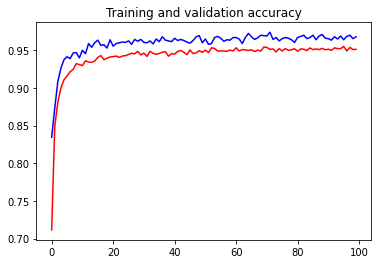

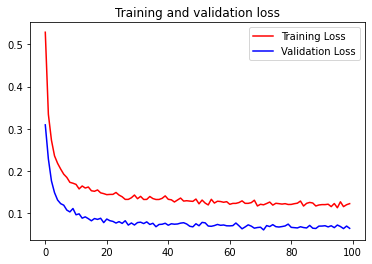

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Saving the model

In [25]:
saved_model_path = "/content/drive/MyDrive/Capstone/fire_detection_v4.h5"

model.save(saved_model_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
model.save('/content/drive/MyDrive/Capstone/fire_detection_v4')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/fire_detection_v4/assets


# Prediciting new data

In [60]:
import numpy as np
from keras.preprocessing import image
path = "/content/drive/MyDrive/Capstone/ShareX_5SXBgMiAjv.png"
img = image.load_img(path, target_size=(224,224))

x = image.img_to_array(img)
x = tf.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

prediction = model.predict(x)
print(prediction)
print(path + " is not fire" if prediction[0][0] > 0 else path + " is fire")


[[5.274464]]
/content/drive/MyDrive/Capstone/ShareX_5SXBgMiAjv.png is not fire


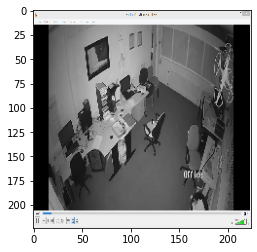

In [61]:
import matplotlib.pyplot as plt
plt.imshow(img)